## Import modules

In [21]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit
import uproot
import pandas

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets i usually use, you can find them in the git-repo
import socket
#if 'jupyter-schmitse-' in socket.gethostname():
#    mpl.rcParams['text.usetex'] = False # no latex on binder
    
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)
#plt.rcParams['text.usetex'] = True
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

### Open ntuple

In [59]:
path = '/afs/cern.ch/user/p/pgaigne/xiccpp/Xicc/TMVA/job26-CombDVntuple-full-evts-TMVA.root'
path = "/eos/lhcb/user/p/pgaigne/job30-CombDVntuple-95%-evts-0-Xicc-TMVA.root"
path1 = "/eos/lhcb/user/p/pgaigne/job30-CombDVntuple-95%-evts-0-Xicc-TMVA.root"

path  = "/eos/lhcb/user/p/pgaigne/Collision-2016-MU-Xicc-job38-MVA.root"
path1 = "/eos/lhcb/user/p/pgaigne/Collision-2016-MD-Xicc-job30-MVA.root"

year = "2018"

if year == 2017:
    paths=["/eos/lhcb/user/p/pgaigne/job78-DV-Xiccpp-Collision-2017-MD-0-MVA.root",
           "/eos/lhcb/user/p/pgaigne/job80-DV-Xiccpp-Collision-2017-MU-0-MVA.root"]
    
elif year == 2018:
    paths=["/eos/lhcb/user/p/pgaigne/job79-DV-Xiccpp-Collision-2018-MD-0-MVA.root",
           "/eos/lhcb/user/p/pgaigne/job81-DV-Xiccpp-Collision-2018-MU-0-MVA.root"]
    
elif year == 2016:
    paths=["/eos/lhcb/user/p/pgaigne/job74-DV-Xiccpp-Collision-2016-MD-0-MVA.root",
           "/eos/lhcb/user/p/pgaigne/job74-DV-Xiccpp-Collision-2016-MD-1-MVA.root",
           "/eos/lhcb/user/p/pgaigne/job75-DV-Xiccpp-Collision-2016-MU-0-MVA.root",
           "/eos/lhcb/user/p/pgaigne/job75-DV-Xiccpp-Collision-2016-MU-1-MVA.root"]
if year == "Run2":
    paths = ["/eos/lhcb/user/p/pgaigne/LHCb-ANA-2019-011/XiccPP2LcKpipi/data-files/XiccPP2LcKpipi_2016.root",
             "/eos/lhcb/user/p/pgaigne/LHCb-ANA-2019-011/XiccPP2LcKpipi/data-files/XiccPP2LcKpipi_2017.root",
             "/eos/lhcb/user/p/pgaigne/LHCb-ANA-2019-011/XiccPP2LcKpipi/data-files/XiccPP2LcKpipi_2018.root"]
    
else :
    paths = [f"/eos/lhcb/user/p/pgaigne/LHCb-ANA-2019-011/XiccPP2LcKpipi/data-files/XiccPP2LcKpipi_{year}.root"]

# paths = [f"/eos/lhcb/user/p/pgaigne/LHCb-ANA-2019-011/XiccPP2LcKpipi/data-files/XiccPP2LcKpipi_{year}.root"]

# paths=["/eos/lhcb/user/p/pgaigne/job74-DV-Xiccpp-Collision-2016-MD-0-MVA-WS.root",
#        "/eos/lhcb/user/p/pgaigne/job74-DV-Xiccpp-Collision-2016-MD-1-MVA-WS.root",
#        "/eos/lhcb/user/p/pgaigne/job75-DV-Xiccpp-Collision-2016-MU-0-MVA-WS.root",
#        "/eos/lhcb/user/p/pgaigne/job75-DV-Xiccpp-Collision-2016-MU-1-MVA-WS.root"]

data_df = pandas.DataFrame([])
for path in paths :
    file =  uproot.open(path)
    tree = file['DecayTree']

    branches_we_want = ["C_M","C_DTF_M","Lc_M","C_BDT","Polarity"] 
    data_df0 = tree.arrays(expressions = branches_we_want, library='pd')

    file.close()
    
    data_df = pandas.concat([data_df0, data_df])

# file =  uproot.open(path1)
# tree = file['DecayTree']

# data_df1 = tree.arrays(expressions = branches_we_want, library='pd')

# file.close()

# data_df = pandas.concat([data_df0, data_df1])


# note, these are the maximum likelihood estimators for both the 
# mean of a distribution and the variance (std = sqrt(variance))
# create a sample with size 3000 that follow a normal distribution
zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)

## BDT response

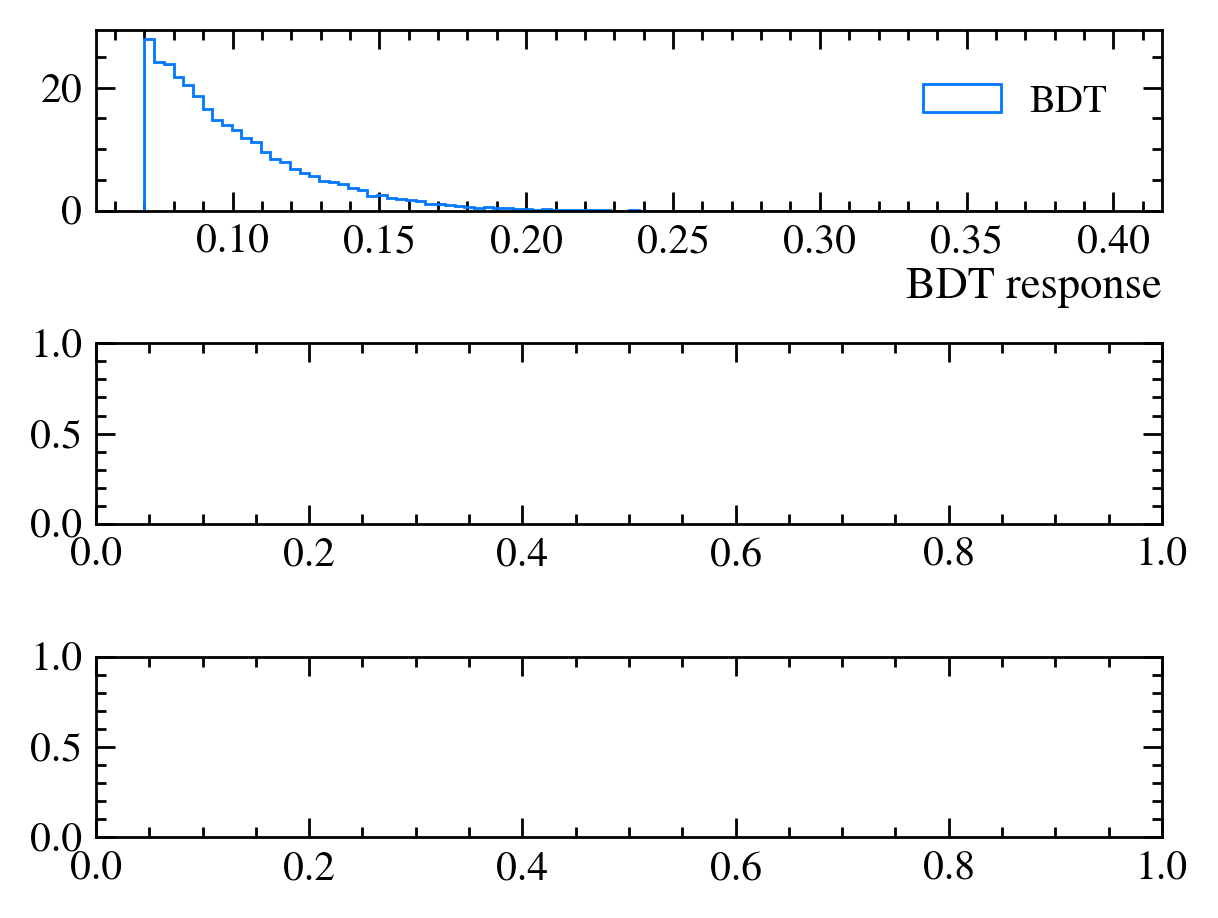

In [60]:
fig, axs = plt.subplots(3, 1)

axs[0].hist(data_df['C_BDT'] , bins=100, density = True, range=[0.07, 0.4], label="BDT", histtype='step')
axs[0].set_xlabel("BDT response")
axs[0].legend()



## Apply cut on data

In [61]:


Xicc_M_before_cut = data_df.C_DTF_M
#data_with_cuts_df = data_df.query("BDTG>0.96 & abs(Lc_M-2288)<18")
#data_with_cuts_df = data_df.query("MLP>0.55 & abs(Lc_M-2288)<18")
data_with_cuts_df = data_df.query("C_BDT>0.07 & abs(Lc_M-2288)<18")

Xicc_M_after_cut = data_with_cuts_df.C_DTF_M

print(f'Number of events: before cut={len(Xicc_M_before_cut)} and after cut={len(Xicc_M_after_cut)}')

Number of events: before cut=20350 and after cut=20350


In [62]:
obs_min = 3470
obs_max = 3770
obs_bin_width = 3
obs_bin = int((obs_max-obs_min)/obs_bin_width)

data = Xicc_M_after_cut

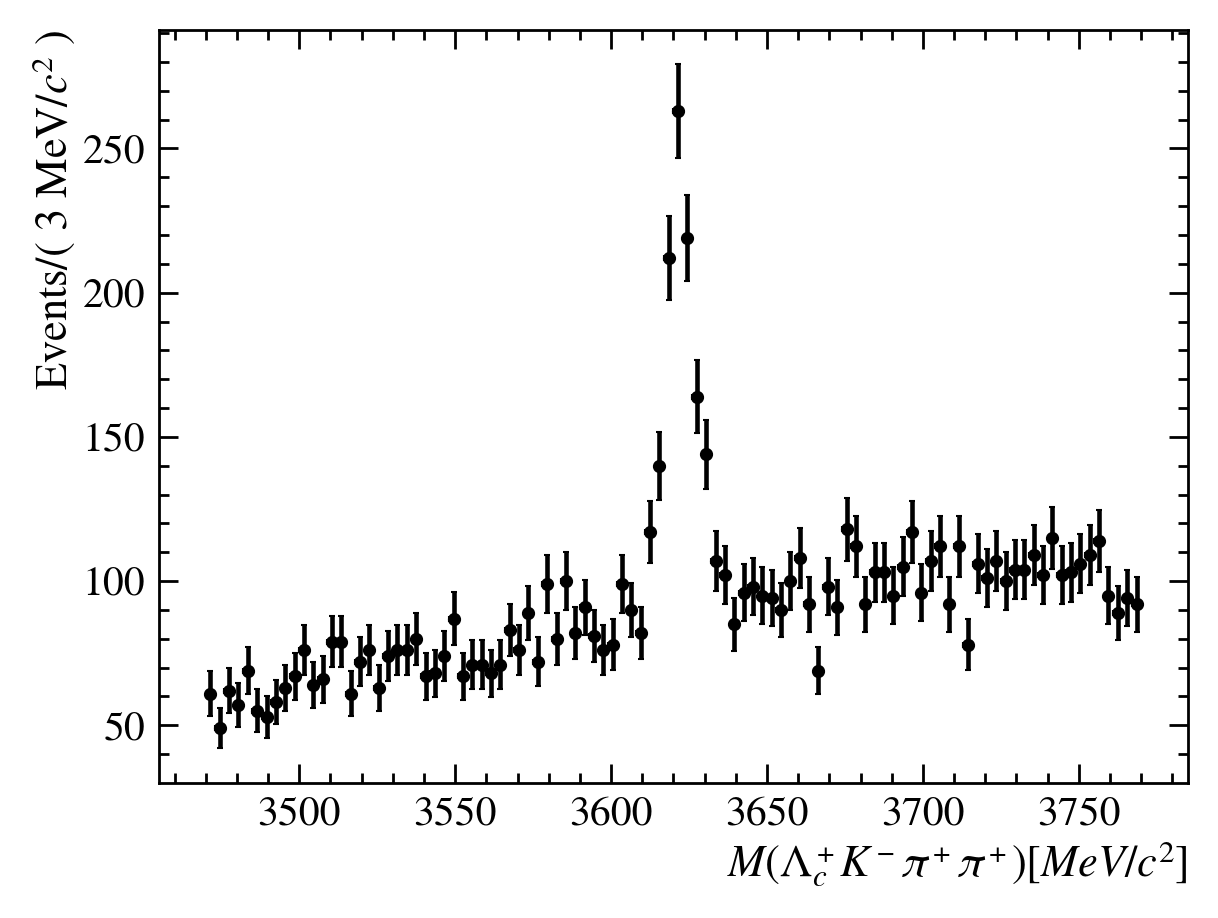

In [63]:
# visualise the data using a histogram:
def plot_data(data):
    fig, ax = plt.subplots()
    # histogram with centered bins
    histo = hist.Hist(hist.axis.Regular(obs_bin, obs_min, obs_max, label='Observable'))
    histo.fill(data)
    # errorbar histogram for the data
    ax.errorbar(histo.axes.centers[0], histo.values(), xerr=histo.axes.widths[0]/2,
            yerr=np.sqrt(histo.values()), fmt='.', label='Data', color='black')
    # labels
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )')

plot_data(Xicc_M_before_cut)

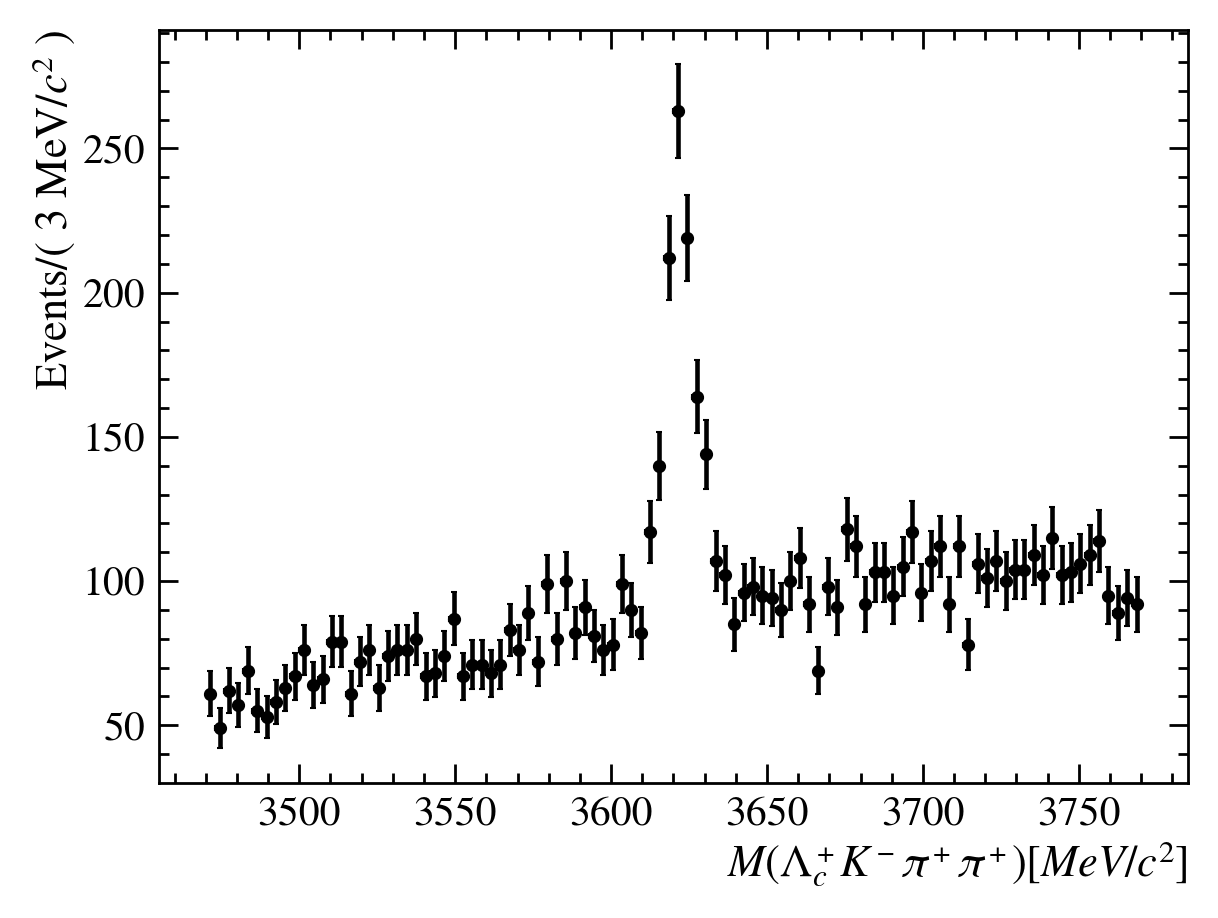

In [64]:
# alternatively you can plot the hist with the plotting api of hist
plot_data(Xicc_M_after_cut)

## Density plot before and after cut

In [65]:
def plot_mass(data, label = None, density = False, bins = obs_bin):
    h, bins = np.histogram(data, bins=bins, range=[obs_min, obs_max])
    mplhep.histplot(h, bins, density=density, yerr=True, label = label)
    plt.xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    plt.ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )')
    plt.xlim(bins[0], bins[-1])

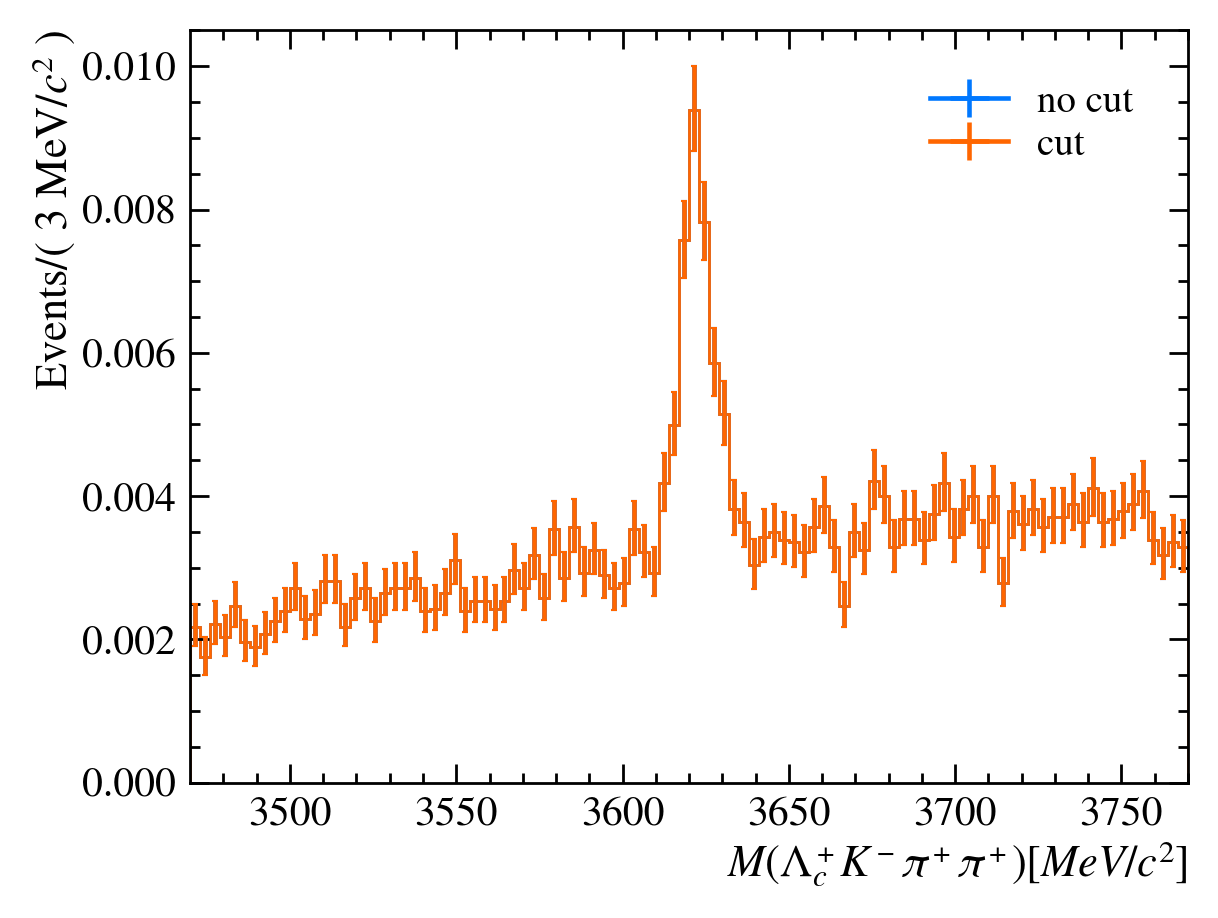

In [66]:
plot_mass(Xicc_M_before_cut , density = True , label = r"no cut")
plot_mass(Xicc_M_after_cut , density = True  , label = r"cut")
plt.legend(loc='best')

## Fitting Composite Models

In real life, usually the data we deal with is not described by a "simple" gaussian but also features some backgrounds that pollute the data in the signal region. 
In the case that one can make assumptions about the shape of the background distribution we can fit the combined background and signal shape to the data. 

In `zfit` this functionality is implemented by the ability to "add" up different models. It can be done with **fractions** of the respective model with respect to all or with **extended models**. Extended models are models that have a "**yield**" associated to them. 

In [67]:

data_all = data.to_numpy()

# new observable and zfit data
obs_bkg = zfit.Space('Observable with Background', limits=(obs_min, obs_max))
data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)


In [68]:
# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_signal, sigma=sigma_signal, name='Signal')
gaussian_ext = gaussian.create_extended(n_signal)

exponential = zfit.pdf.Exponential(obs=obs_bkg, lam=slope_bkg, name='Background')
exponential_ext = exponential.create_extended(n_bkg)

# build the model as the sum of the gaussian and the exponential functions
model = zfit.pdf.SumPDF([gaussian_ext, exponential_ext])

# SumPDF with fraction instead of yield parameters
# frac = zfit.Parameter('frac', 0.5, 0.1, 0.9)
# model = zfit.pdf.SumPDF([gaussian, exponential], fracs=[frac])

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

### Minimization

In [69]:
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
result_ext.errors(method='minuit_minos', name='minuit_minos')
result_ext

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_10, Composed_autoparam_11]] data=[<zfit.core.data.Data object at 0x7f10f4150e20>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00023 │ 398.5865    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value  (rounded)    minuit_hesse         minuit_minos    at limit
------------  ------------------  --------------  -------------------  ----------
n_signal                  688.24     +/-      41  -     40   +     41       False
n_bkg                    8648.34     +/-      98  -     98   +     98       False
mu_signal                3622.16     +/-    0.34  -   0.34   +   0.34   

In [70]:
mean = mu_signal.value().numpy()
result_ext.hesse()[mu_signal]['error']

0.34260381311975274

## Plot the fitting result after cut

In [71]:
Y = float(n_signal)
Y_err = result_ext.hesse()[n_signal]['error']
mu = float(mu_signal)
mu_err = result_ext.hesse()[mu_signal]['error']
sigma = float(sigma_signal)
sigma_err = result_ext.hesse()[sigma_signal]['error']
bkg = float(n_bkg)
bkg_err = result_ext.hesse()[n_bkg]['error']

sigma_width = 2.5

integral_norm_gauss = gaussian.integrate(limits=(mu-sigma_width*sigma, mu+sigma_width*sigma))
integral_norm_exp = exponential.integrate(limits=(mu-sigma_width*sigma, mu+sigma_width*sigma))

B = float(integral_norm_exp*bkg)
print('Signal yield :',Y,'Background :',B)
S = Y/np.sqrt(Y+B)
print('Local significance :', S)

SNR = Y/B

Signal yield : 688.2395629882812 Background : 744.0414813344375
Local significance : 18.185511128813342


In [72]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb 2016'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*m.get_yield()).numpy()*area/nbins
                for m in zmodel.get_models()]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');
    
    textstr = '\n'.join((
    r'$\mu_m=%.2f \pm %.2f $ MeV/$c^2$' % (mu, mu_err ),
    r'$\sigma_m=%.2f \pm %.2f $ MeV/$c^2$' % (sigma, sigma_err ),
    r'$N_{bkg}=%.0f \pm %.0f$' % (bkg, bkg_err),
    r'$N_{sig}=%.0f \pm %.0f$' % (Y, Y_err),
    r'$S=%.1f \sigma$' % (S, ),
    r'$SNR_{%.1f \sigma}=%.2f $' % (sigma_width,SNR )))
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top')
    
    # legend and axis labels
    ax.legend(artists, labels, loc='upper left', 
              title=title, title_fontsize=20)

#plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np, zmodel=model)


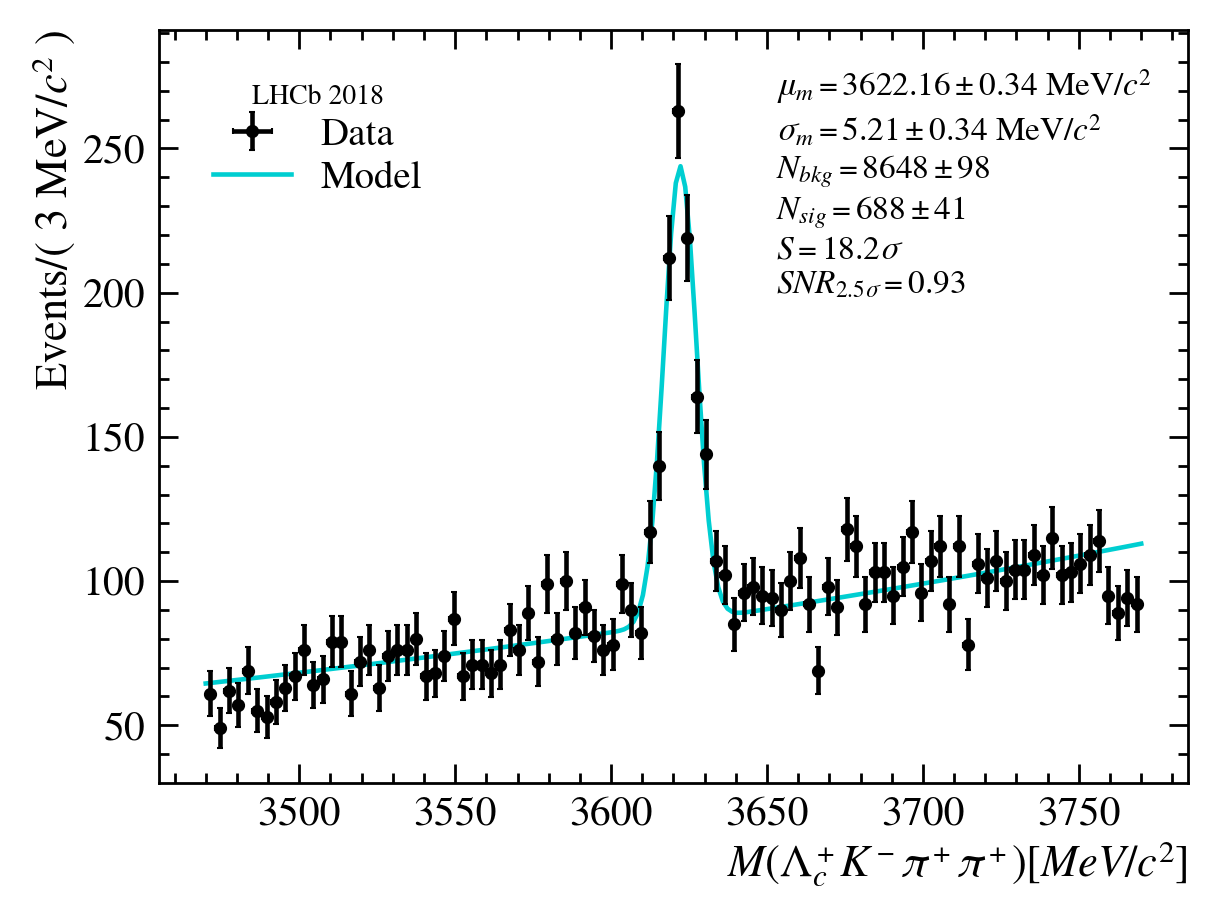

In [73]:
# visualise as we have discussed before
# with the addition of this helper function for the uncertainties
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values([n_signal, n_bkg, mu_signal, sigma_signal, slope_bkg], pars):
        pdf = model.pdf(basis) * (n_signal.numpy()+n_bkg.numpy())
    return pdf

# the model as the sum of the individual pdfs
basis_pdf = np.linspace(obs_min, obs_max, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy()+n_bkg.numpy())

# the uncertainty computation on our model given the parameters
mean_params = [result_ext.params[p]['value'] for p in result_ext.params.keys()]
covariance = result_ext.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
smodel_pdf_np = np.std([eval_zfit_model(model, basis_pdf, pars) for pars in rnd_pars], ddof=1, axis=0)

# plotting all together
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, title=f'LHCb {year}')#, smodel=smodel_pdf_np)

With just a few modifications to the plotting script we can also visualise the sub-models of our composed model: 

In [74]:
print([m for m in model.get_models()])

[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu_signal, sigma_signal], <zfit.<class 'zfit.models.basic.Exponential'>  params=[slope_bkg]]


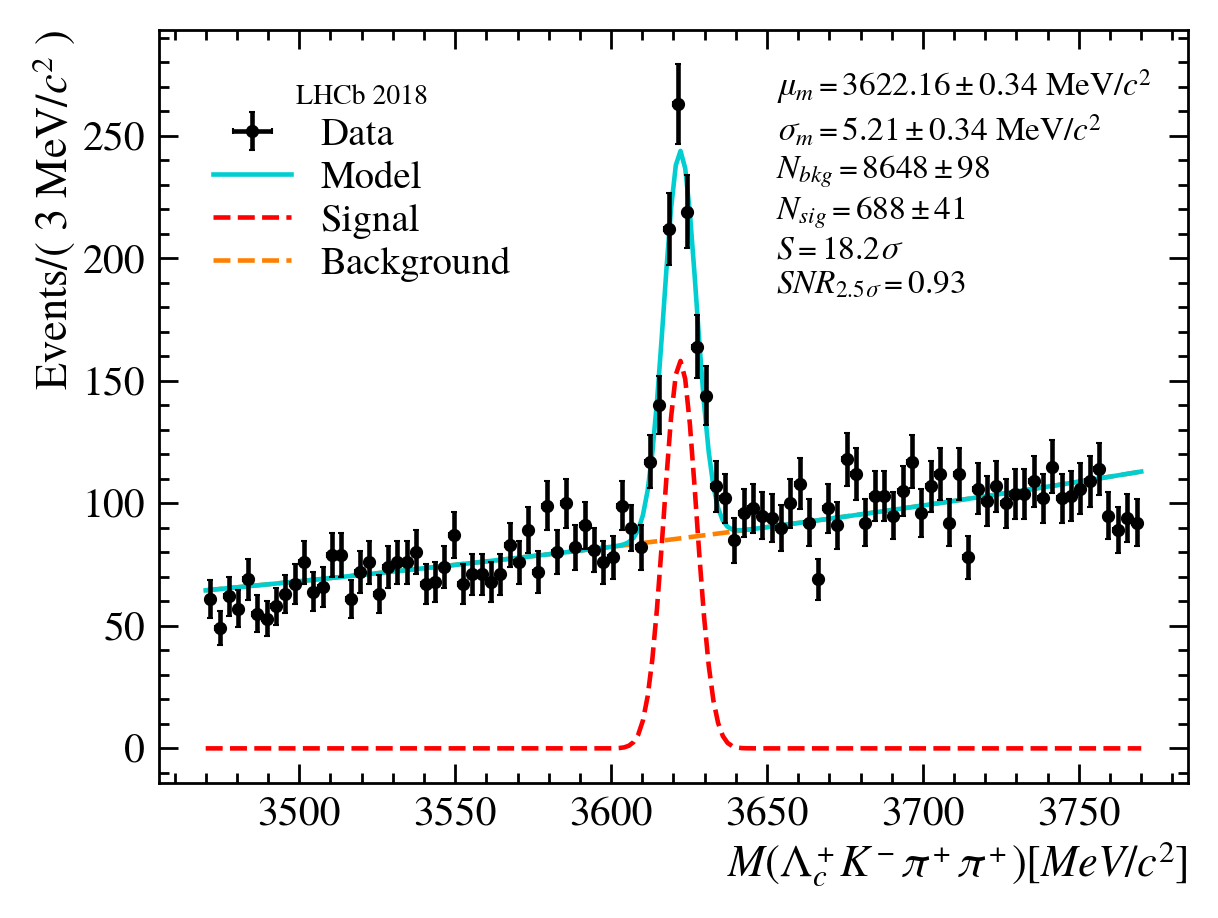

In [75]:
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model, title=f'LHCb {year}')

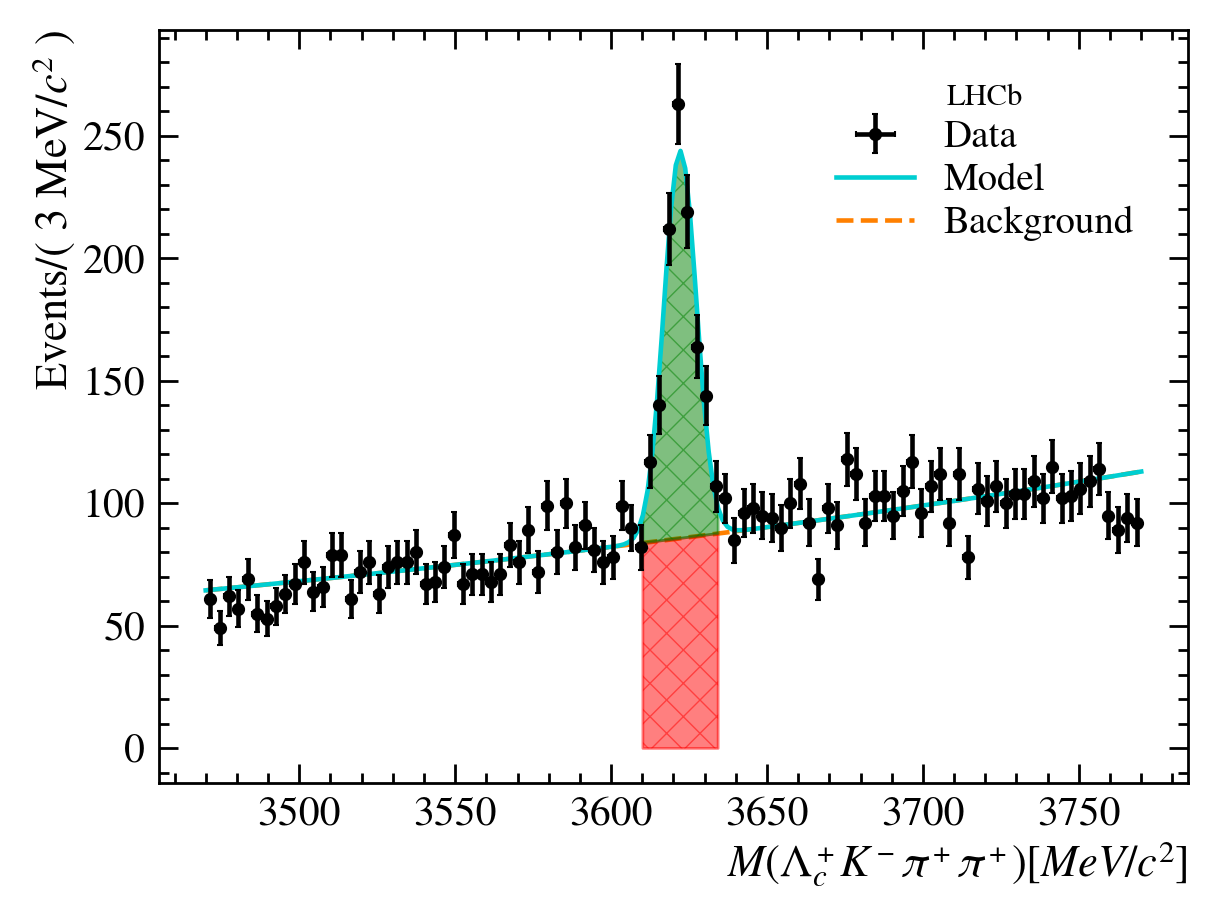

In [76]:
def plot_fit_area(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*m.get_yield()).numpy()*area/nbins
                for m in zmodel.get_models()]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        labels.pop(2) #remove 'signal' name from legend
        #for mdex, pdf in enumerate(pdfs):
         #   artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
         #                          linestyle='--', zorder=-1)[0])
        artists.append(ax.plot(basis, pdfs[1], color=cmap(norm(1)), linestyle='--', zorder=-1)[0]) # plot only bkg model
        ax.fill_between(basis, pdfs[1], 0, edgecolor='red',color='red',hatch = 'X', where = (basis > mu-sigma_width*sigma) & (basis <= mu+sigma_width*sigma),
                 alpha=0.5)
        ax.fill_between(basis, model * area/nbins, pdfs[1],hatch = 'X', edgecolor='green', color='green',
                 where = (basis > mu-sigma_width*sigma) & (basis <= mu+sigma_width*sigma), alpha=0.5)
                                   
        
    # legend and axis labels
    ax.legend(artists, labels, loc='best', 
              title=title, title_fontsize=22)
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');
    
    

data_all = data.to_numpy()
plot_fit_area(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model)
